In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_keys = ['Carp', 'Telephone']
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params['cur_dc_tag'] = '30of30'
data_params['metric_tag'] = 'activity_index'
data_params['index_time_block'] = 5
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
dt_starts = {'Carp':dt.datetime(2022, 7, 15, 0, 0, 0),
             'Telephone':dt.datetime(2022, 8, 19, 0, 0, 0)}
dt_ends = {'Carp':dt.datetime(2022, 10, 16, 16, 0, 0),
           'Telephone':dt.datetime(2022, 8, 25, 16, 0, 0)}

# for site_key in site_keys:
site_key = site_keys[0]
data_params['start'] = dt_starts[site_key]
data_params['end'] = dt_ends[site_key]
# for type_key in type_keys:
type_key = type_keys[0]
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)

activity_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_actind_TYPE_SITE_summary"]}.csv', index_col=0)
actvtind_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_actind_TYPE_SITE_summary"]}.csv', index_col=0)
activity_arr.index = pd.DatetimeIndex(activity_arr.index)
actvtind_arr.index = pd.DatetimeIndex(actvtind_arr.index)

Carp LF


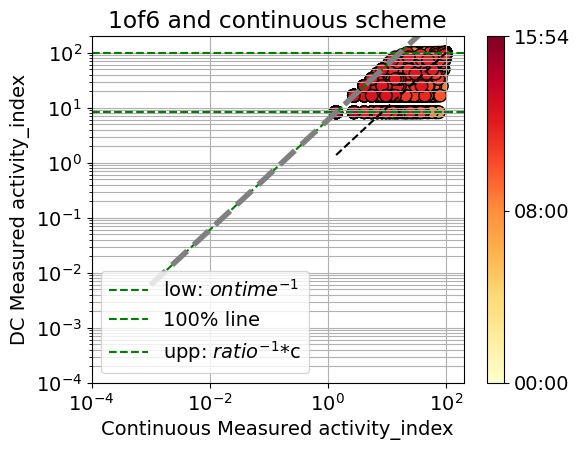

In [5]:
plt.figure(figsize=(6, 4.5))
plt.rcParams.update({'font.size':14})
dc_col = '1of6'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
actind_cont_column = pd.DataFrame(actvtind_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, actind_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, actind_cont_column, data_params)

# test_plc_metr = plt_cmetr[plt_cmetr>50].dropna()
# test_pldc_metr = plt_dcmetr.loc[test_plc_metr.index]
# test_pldc_metr = test_pldc_metr[test_pldc_metr>50]

complot.plot_indiv_dc_control_comp_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params)
p = 5
plt.plot([0.001, 100], [0.001*(1+p), 100*(1+p)], color='grey', linewidth=4, linestyle='dashed')
plt.plot([0.001, 100], [0.001*(1-p), 100*(1-p)], color='grey', linewidth=4, linestyle='dashed')

plt.show()

In [6]:
def get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['activity_inds'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['activity_inds'], index=plt_cmetr.index)
    total_num_points = points_dc.shape[0]

    within_bounds = ((points_dc.values<=points_c.values*(1+p))&(points_dc.values>=points_c.values*(1-p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points
    all_points_bound = p[percent_points_in_bounds==1][0]

    test_true_100_at_factor(points_dc, points_c, all_points_bound)

    return percent_points_in_bounds

def test_true_100_at_factor(points_dc, points_c, all_points_bound):
    test_dc = points_dc[points_dc!=0].dropna()
    test_c = points_c.loc[test_dc.index]
    filt_dc = (test_dc.values>test_c.values*(1+p))|(test_dc.values<test_c.values*(1-p))
    assert filt_dc.all()==False

def get_percent_points_in_bounds_linear(plt_dcmetr, plt_cmetr, p):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['activity_inds'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['activity_inds'], index=plt_cmetr.index)
    total_num_points = points_dc.shape[0]

    within_bounds = ((points_dc.values<=points_c.values+(100*p))&(points_dc.values>=points_c.values-(100*p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points

    return percent_points_in_bounds

def plot_variance_of_points_linear(plt_dcmetr, plt_cmetr, data_params): 
    dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]

    step = 0.01
    p = np.arange(0, 1+step, step)
    percent_points_in_bounds = get_percent_points_in_bounds_linear(plt_dcmetr, plt_cmetr, p)
    points_on_line = percent_points_in_bounds[0]
    all_points_bound = p[percent_points_in_bounds==1.0][0]
    most_points_bound = p[percent_points_in_bounds>=0.95][0]

    plt.title(f'{data_params["metric_tag"]} ({dctag1}) and cont.')
    plt.plot(p, percent_points_in_bounds)
    plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points on line',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=most_points_bound, label=f'95% at {round(100*most_points_bound)}% bounds',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=all_points_bound, label=f'100% at {round(100*all_points_bound)}% bounds',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.grid(which='both')
    plt.xlabel('% bounds')
    plt.xlim(-0.1, 1.1)
    plt.ylim(0.3, 1.1)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=4)

def plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params): 
    dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]

    p = np.arange(0, 6, 0.1) + 1e-14
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p)
    points_on_line = percent_points_in_bounds[0]
    all_points_bound = p[percent_points_in_bounds==1][0]
    most_points_bound = p[percent_points_in_bounds>=0.95][0]

    plt.title(f'{data_params["metric_tag"]} ({dc_col}) and cont.')
    plt.plot(p, percent_points_in_bounds, marker='.', markersize=5)
    plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points on line',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=most_points_bound, label=f'95% at factor={round(most_points_bound)}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=all_points_bound, label=f'100% at factor={round(all_points_bound)}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.grid(which='both')
    plt.xlabel('% bounds')
    plt.xlim(-0.1, 6.1)
    plt.ylim(0.3, 1.1)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=4)

def plot_all_dc_scheme_variance_of_points_linear(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(4*len(data_params['percent_ons']), 4*len(data_params['cycle_lengths'])))
    plt.rcParams.update({'font.size':12})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_variance_of_points_linear(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

def plot_all_dc_scheme_variance_of_points_log(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(4*len(data_params['percent_ons']), 4*len(data_params['cycle_lengths'])))
    plt.rcParams.update({'font.size':12})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

In [7]:
plt.figure(figsize=(4.5, 4.5))
plt.rcParams.update({'font.size':14})
dc_col = '2of6'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
actind_cont_column = pd.DataFrame(actvtind_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, actind_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, actind_cont_column, data_params)

# plot_variance_of_points_linear(plt_dcmetr, plt_cmetr, data_params)

dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
total = int(dc_tag_split[-1])
on = int(dc_tag_split[0])
listening_ratio = on/total
dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]

step = 0.01
p = np.arange(0, 6+step, step)
# percent_points_in_bounds = get_percent_points_in_bounds_linear(plt_dcmetr, plt_cmetr, p)


<Figure size 450x450 with 0 Axes>

In [9]:

points_dc = pd.DataFrame(plt_dcmetr.values, columns=['activity_inds'], index=plt_dcmetr.index)
points_c = pd.DataFrame(plt_cmetr.values, columns=['activity_inds'], index=plt_cmetr.index)


In [10]:
points_c

,activity_inds
datetime_UTC,
2022-07-15 00:00:00,0.0
2022-07-15 00:06:00,0.0
2022-07-15 00:12:00,0.0
2022-07-15 00:18:00,0.0
2022-07-15 00:24:00,0.0
...,...
2022-10-16 15:30:00,0.0
2022-10-16 15:36:00,0.0
2022-10-16 15:42:00,0.0


In [11]:
points_dc

,activity_inds
datetime_UTC,
2022-07-15 00:00:00,0.0
2022-07-15 00:06:00,0.0
2022-07-15 00:12:00,0.0
2022-07-15 00:18:00,0.0
2022-07-15 00:24:00,0.0
...,...
2022-10-16 15:30:00,0.0
2022-10-16 15:36:00,0.0
2022-10-16 15:42:00,0.0


In [13]:
points_c = points_c[points_c!=0].dropna()
points_dc = points_dc.loc[points_c.index]

In [14]:
points_c

,activity_inds
datetime_UTC,
2022-07-15 04:54:00,1.388889
2022-07-15 05:06:00,6.944444
2022-07-15 05:24:00,4.166667
2022-07-15 05:48:00,1.388889
2022-07-15 05:54:00,18.055556
...,...
2022-10-16 03:18:00,6.944444
2022-10-16 04:18:00,5.555556
2022-10-16 04:42:00,6.944444


In [15]:
points_dc

,activity_inds
datetime_UTC,
2022-07-15 04:54:00,4.166667
2022-07-15 05:06:00,0.000000
2022-07-15 05:24:00,0.000000
2022-07-15 05:48:00,0.000000
2022-07-15 05:54:00,0.000000
...,...
2022-10-16 03:18:00,0.000000
2022-10-16 04:18:00,16.666667
2022-10-16 04:42:00,0.000000


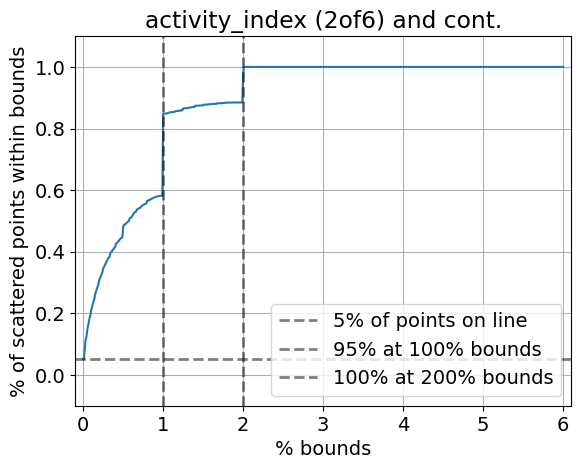

In [17]:
total_num_points = points_dc.shape[0]

within_bounds = ((points_dc.values<=points_c.values*(1+p))&(points_dc.values>=points_c.values*(1-p)))
num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
percent_points_in_bounds = num_points_in_bounds / total_num_points

points_on_line = percent_points_in_bounds[0]
all_points_bound = max((1/listening_ratio)-1, 1.0)
most_points_bound = min((1/listening_ratio)-1, 1.0)

plt.title(f'{data_params["metric_tag"]} ({dctag1}) and cont.')
plt.plot(p, percent_points_in_bounds)
plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points on line',
            linestyle='dashed', color='k', linewidth=2, alpha=0.5)
plt.axvline(x=most_points_bound, label=f'95% at {round(100*most_points_bound)}% bounds',
            linestyle='dashed', color='k', linewidth=2, alpha=0.5)
plt.axvline(x=all_points_bound, label=f'100% at {round(100*all_points_bound)}% bounds',
            linestyle='dashed', color='k', linewidth=2, alpha=0.5)
plt.grid(which='both')
plt.xlabel('% bounds')
plt.xlim(-0.1, 6.1)
plt.ylim(-0.1, 1.1)
plt.ylabel('% of scattered points within bounds')
plt.legend(loc=4)
plt.show()

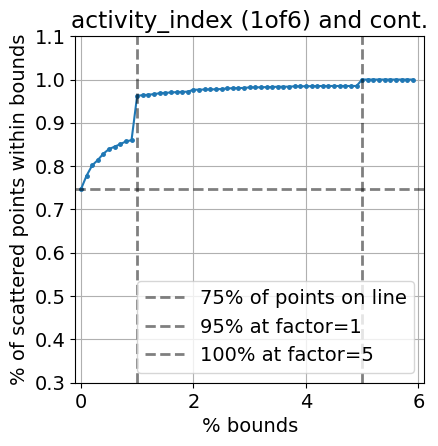

In [52]:
plt.figure(figsize=(4.5, 4.5))
plt.rcParams.update({'font.size':14})
dc_col = '1of6'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
actind_cont_column = pd.DataFrame(actvtind_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, actind_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, actind_cont_column, data_params)

plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params)

plt.show()

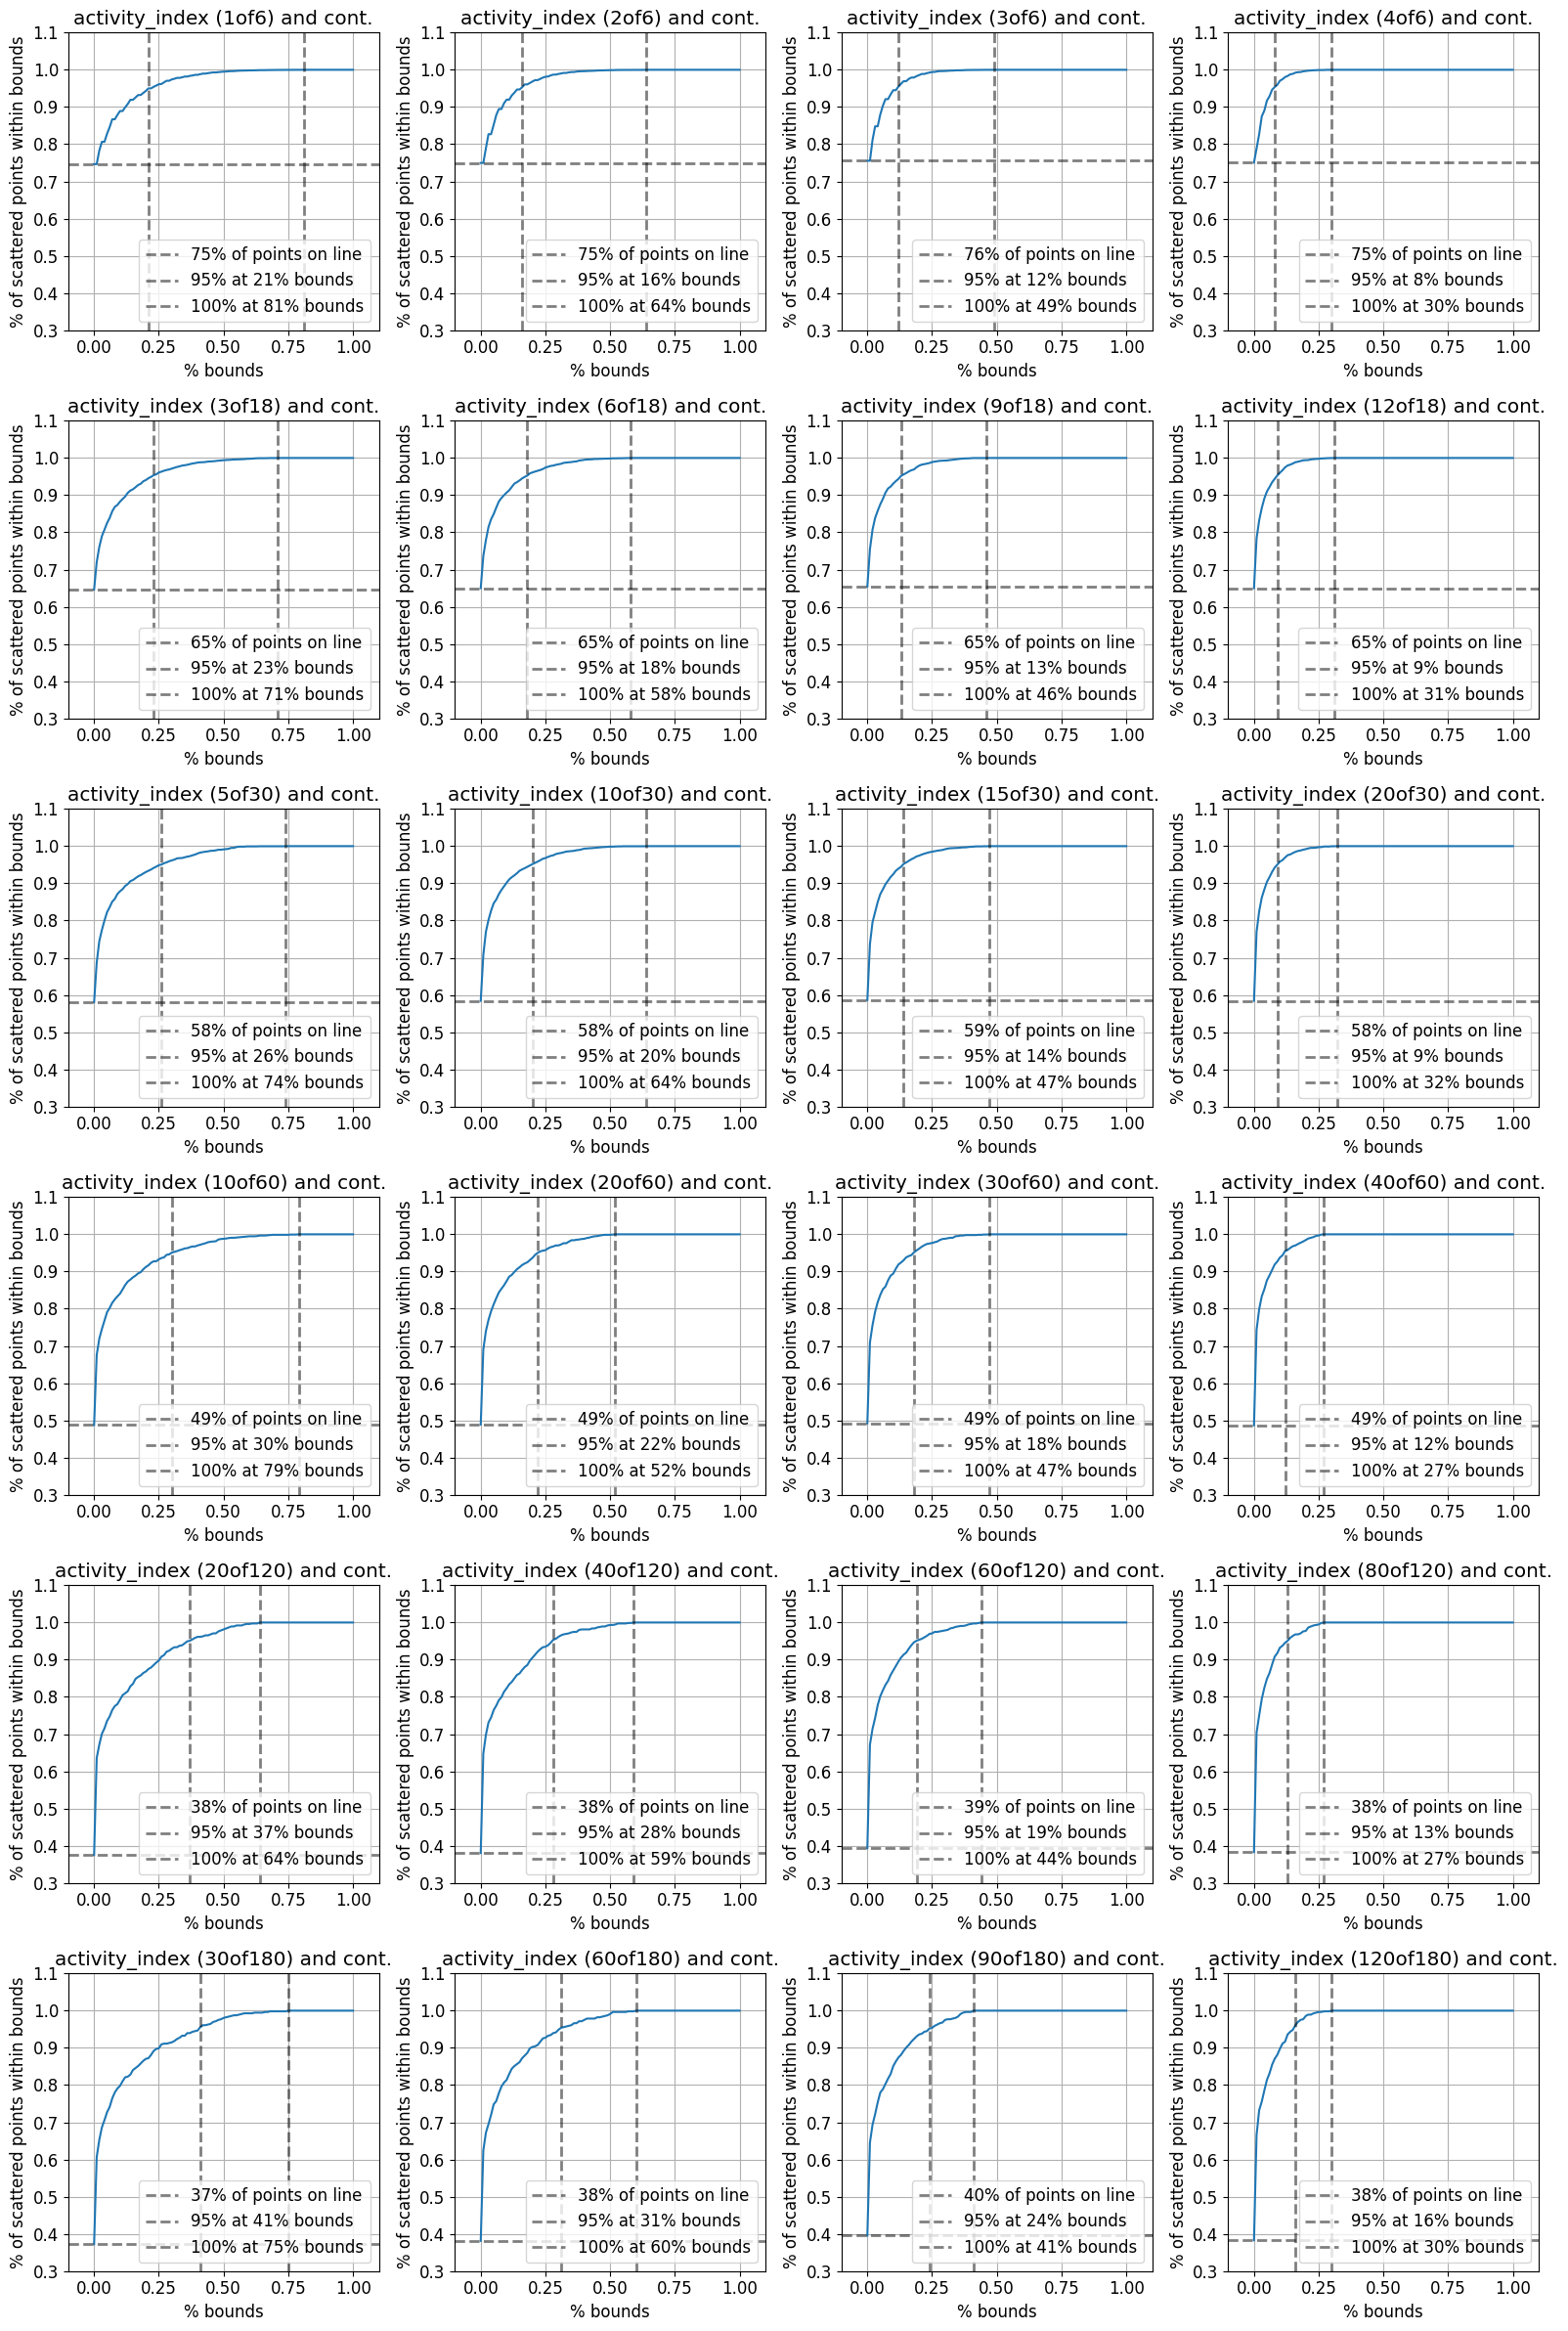

In [53]:
plot_all_dc_scheme_variance_of_points_linear(activity_arr, actvtind_arr, data_params)

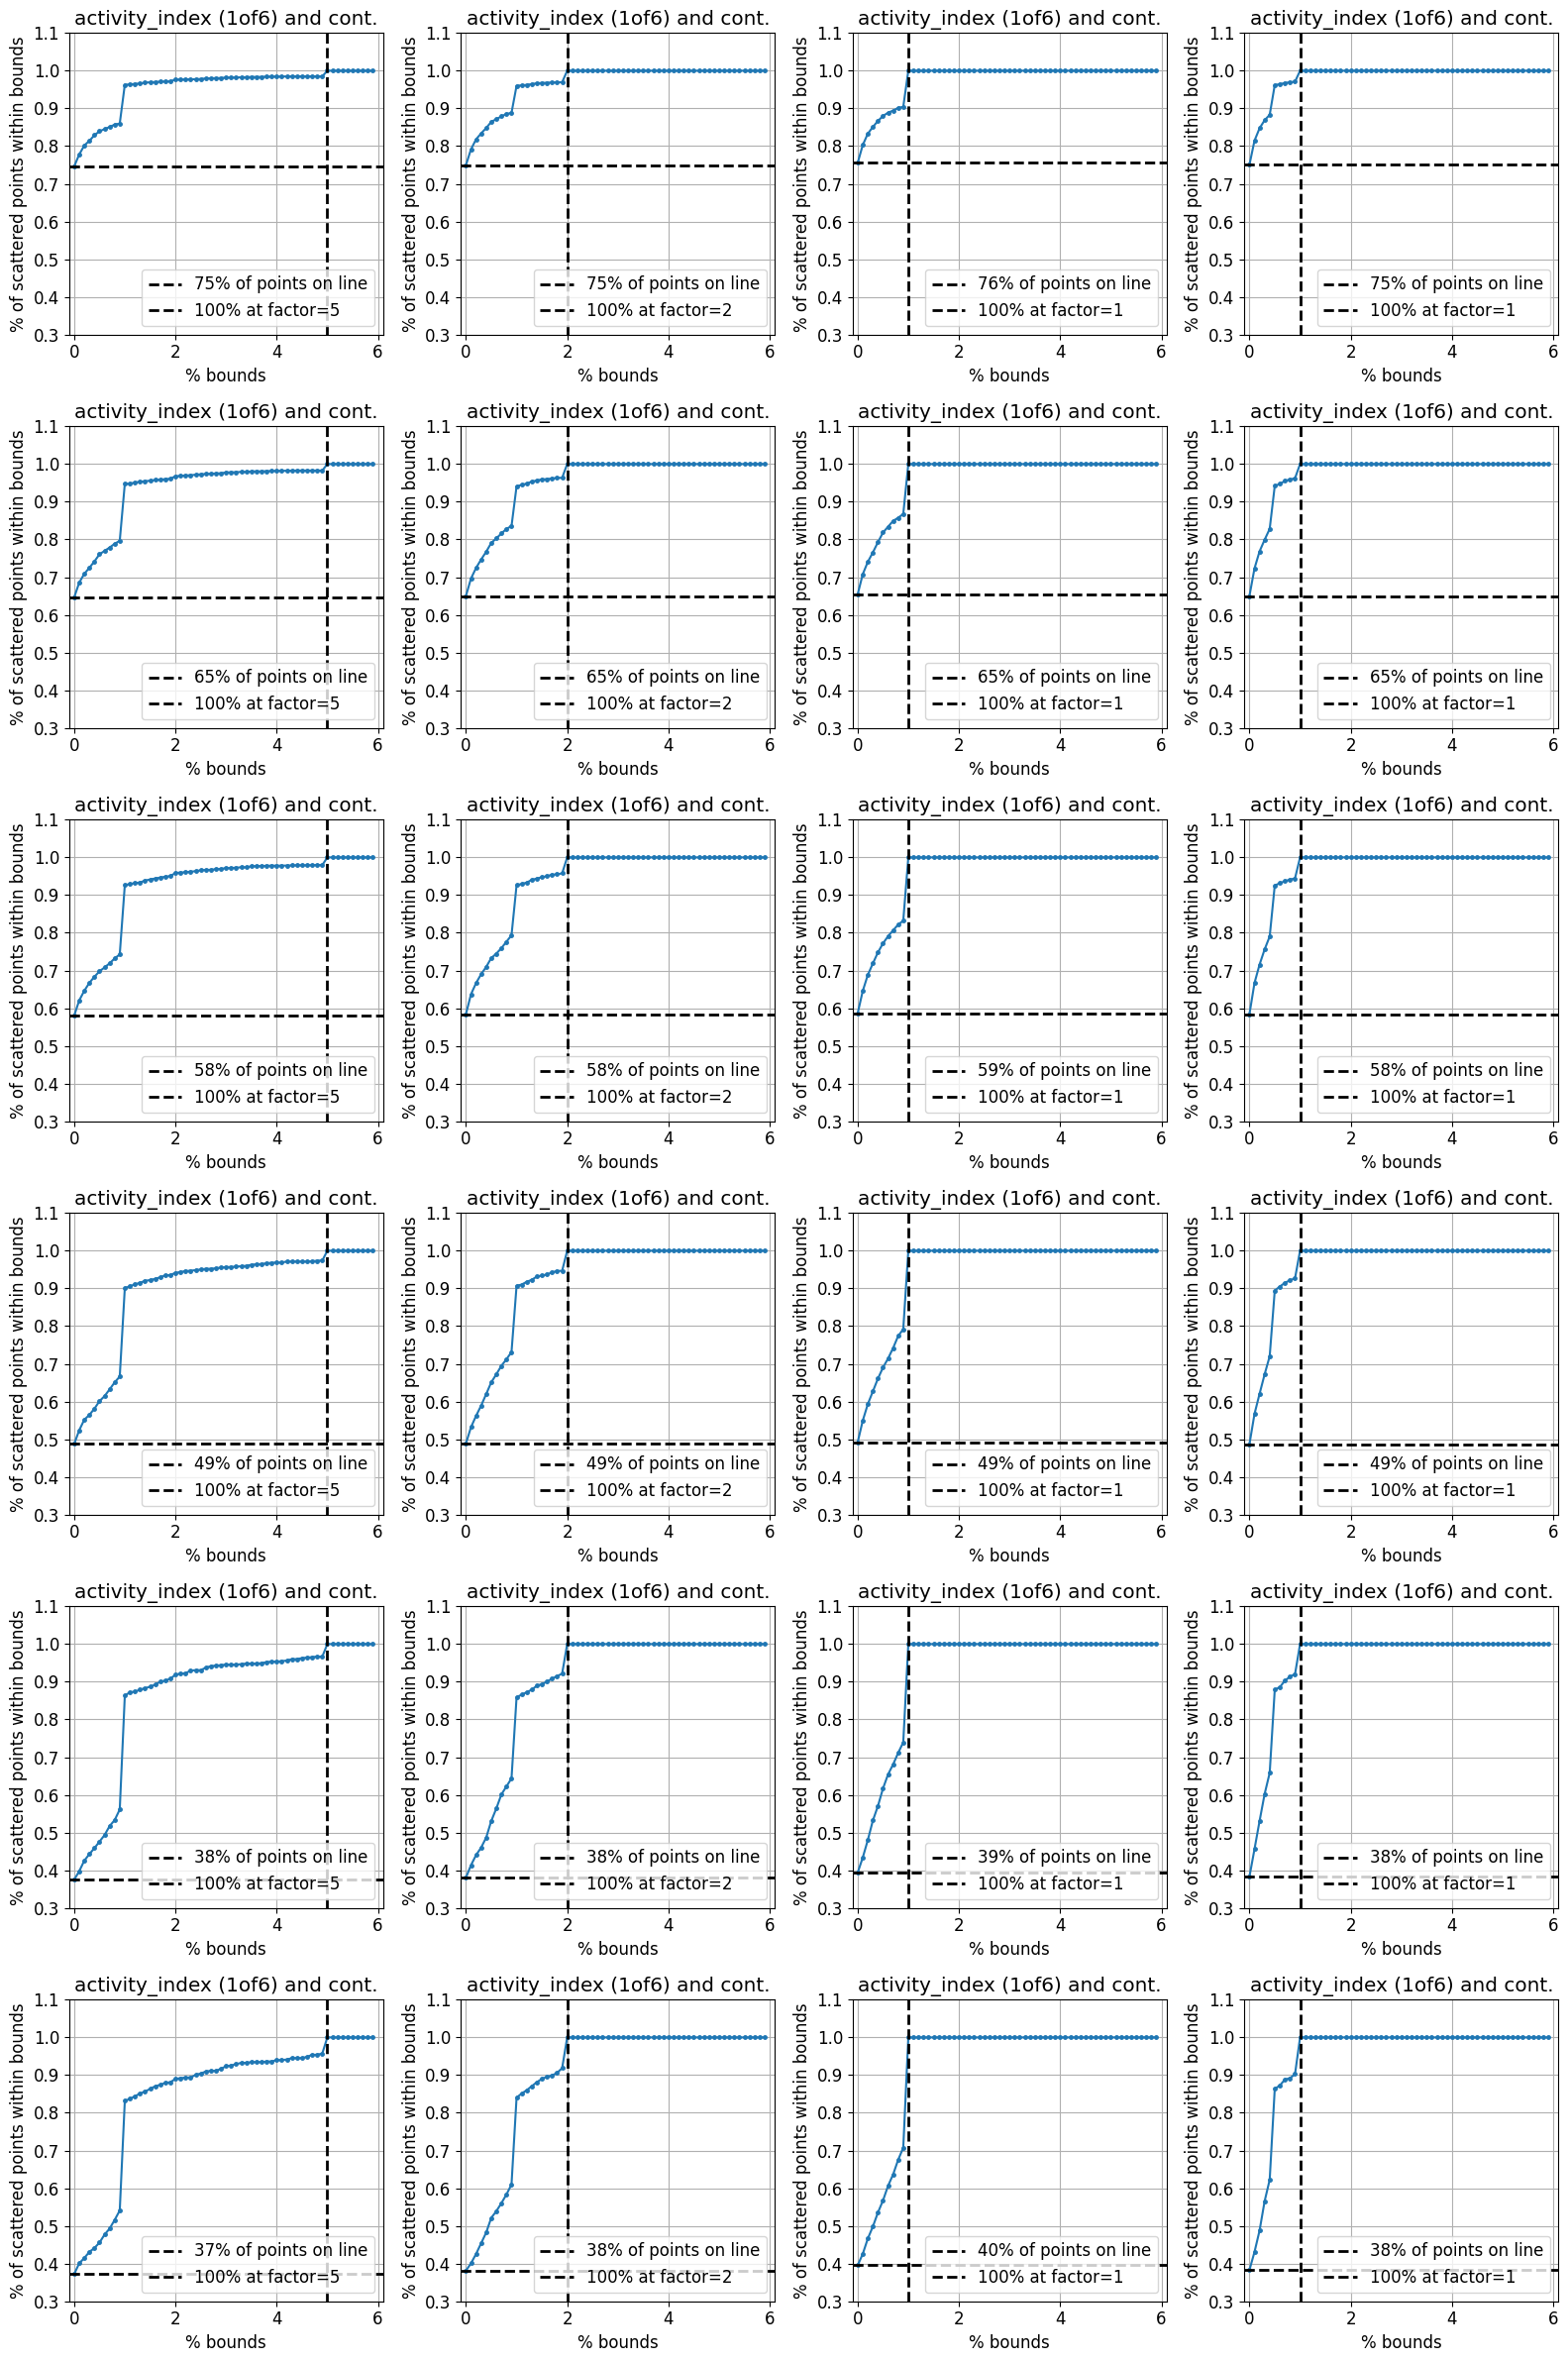

In [24]:
plot_all_dc_scheme_variance_of_points_log(activity_arr, actvtind_arr, data_params)

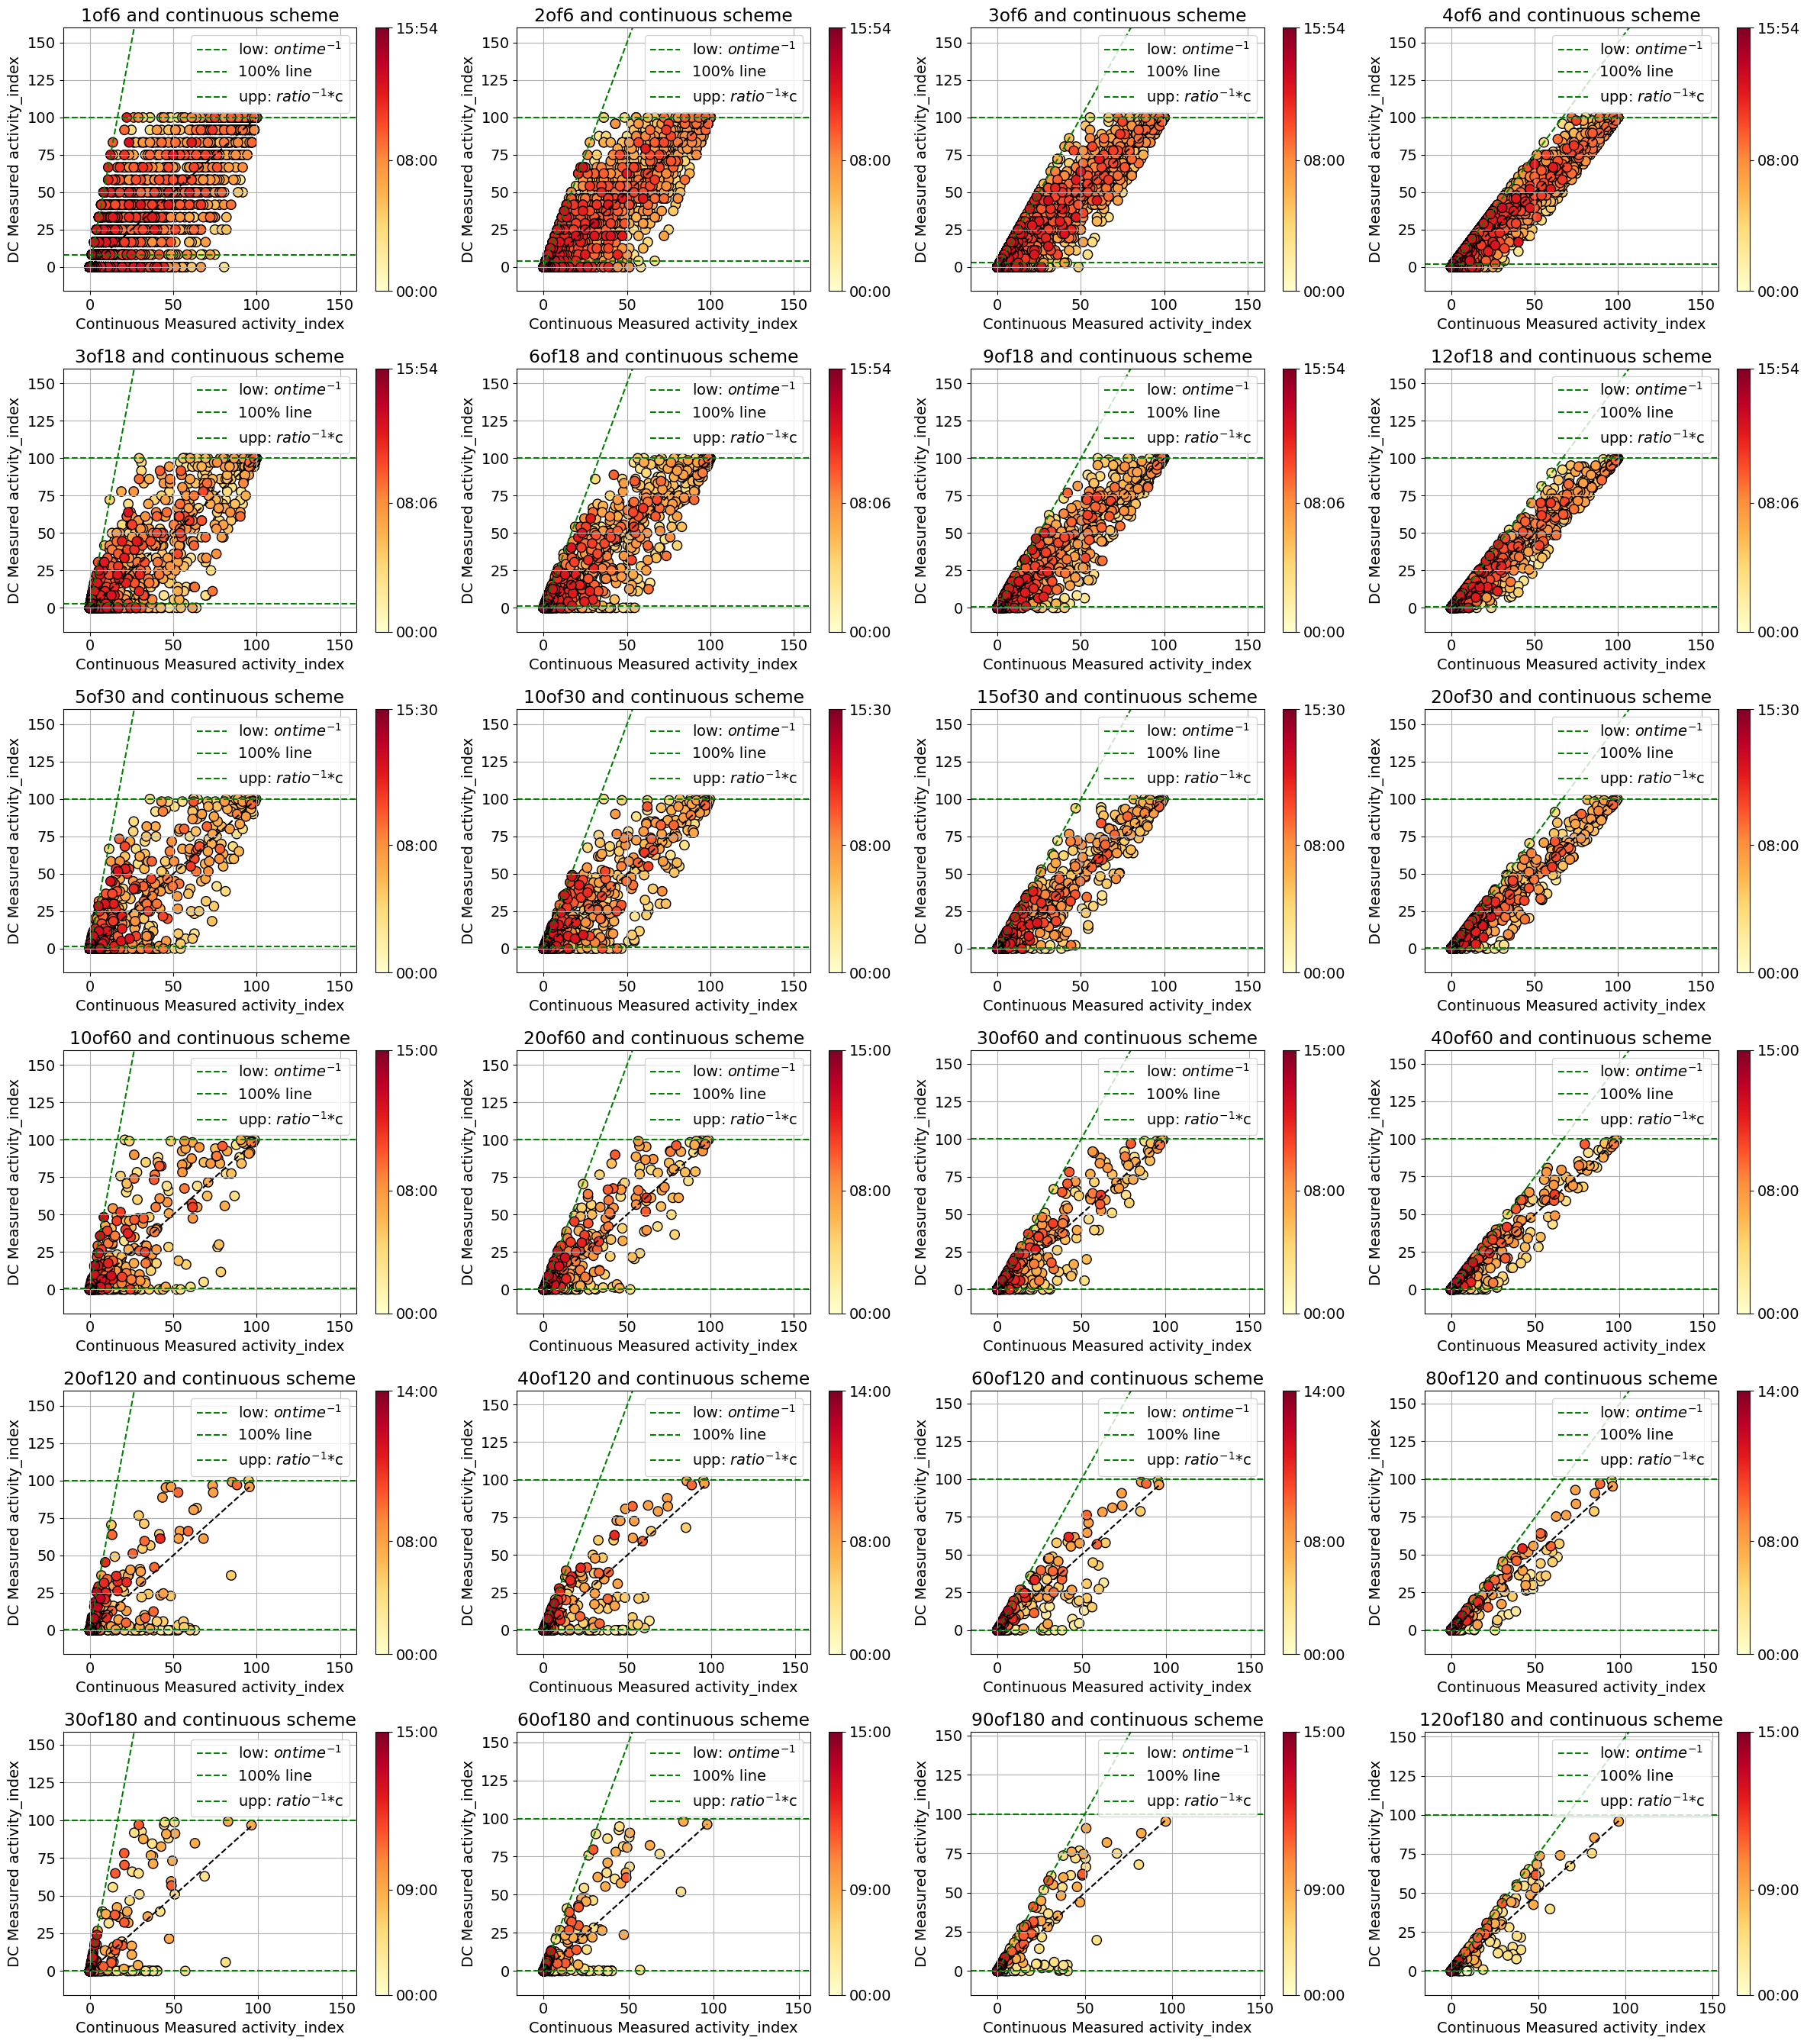

In [297]:
complot.plot_all_dc_scheme_comps_linear_scale(activity_arr, actvtind_arr, data_params)